In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
import joblib
import plotly.graph_objects as go
import mplfinance as mpf

In [10]:
# === RSI ===
def calculate_rsi(df: pd.DataFrame, column: str = "Close", period: int = 14) -> pd.Series:
    delta = df[column].diff()
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# === MACD ===
def calculate_macd(df: pd.DataFrame, column: str = "Close", fast: int = 12, slow: int = 26, signal: int = 9) -> pd.DataFrame:
    ema_fast = df[column].ewm(span=fast, adjust=False).mean()
    ema_slow = df[column].ewm(span=slow, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    histogram = macd_line - signal_line
    df["macd"] = macd_line
    df["macd_signal"] = signal_line
    df["macd_hist"] = histogram
    return df

# === Основна обробка даних ===
def create_data(filepath: str = '/content/EURUSD_M5_202412020005_202507011915.csv') -> tuple:
    df = pd.read_csv(filepath, delimiter='\t')
    df = df.rename(columns={
        '<DATE>': 'Date', '<TIME>': 'Time',
        '<OPEN>': 'Open', '<HIGH>': 'High',
        '<LOW>': 'Low', '<CLOSE>': 'Close'
    })
    df.drop(columns=['<TICKVOL>', '<VOL>', '<SPREAD>'], inplace=True)

    df['rsi'] = calculate_rsi(df)
    df = calculate_macd(df)

    df = df.dropna().reset_index(drop=True)

    # === Вибрані фічі ===
    features = ['Open', 'High', 'Low', 'Close', 'rsi', 'macd']
    data = df[features].values

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)

    return scaled_data, scaler, df

# === Створення послідовностей ===
def create_sequences(data: np.ndarray, window: int = 120) -> tuple:
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i - window:i])
        y.append(data[i, 0:4])  # прогнозуємо Open, High, Low, Close
    return np.array(X), np.array(y)

# === Train / Test Split ===
def train_and_test(X: np.ndarray, y: np.ndarray, train_ratio: float = 0.8) -> tuple:
    split = int(train_ratio * len(X))
    return X[:split], X[split:], y[:split], y[split:]

In [11]:
def train_lstm(X_train, y_train, X_test, y_test, scaler, epochs=20, batch_size=16):
    """
    Навчання LSTM для прогнозу OHLC (Open, High, Low, Close)
    """
    n_features = X_train.shape[2]      # Кількість фіч на вхід
    n_outputs = y_train.shape[1]       # Має бути 4 (Open, High, Low, Close)

    # === Побудова моделі ===
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train.shape[1], n_features)))
    model.add(LSTM(64))
    model.add(Dropout(0.2))
    model.add(Dense(n_outputs))  # Прогнозуємо OHLC

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

    # === Навчання ===
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[early_stop],
                        verbose=1)

    # === Прогноз на тесті ===
    y_pred = model.predict(X_test, verbose=0)  # (samples, 4)

    # === Inverse Transform для реальних значень ===
    n_total_features = X_train.shape[2]
    pad_width = n_total_features - n_outputs

    y_pred_full = np.concatenate([y_pred, np.zeros((len(y_pred), pad_width))], axis=1)
    y_test_full = np.concatenate([y_test, np.zeros((len(y_test), pad_width))], axis=1)

    y_pred_real = scaler.inverse_transform(y_pred_full)[:, :n_outputs]
    y_test_real = scaler.inverse_transform(y_test_full)[:, :n_outputs]

    # === Метрики ===
    mae = mean_absolute_error(y_test_real, y_pred_real)
    rmse = mean_squared_error(y_test_real, y_pred_real)

    print(f"\n📊 MAE: {mae:.5f}, RMSE: {rmse:.5f}")
    print(f"📈 Прогнозовано {len(y_pred_real)} OHLC точок")

    # === Збереження ===
    model.save("model_OHLC.keras")
    joblib.dump(scaler, "scaler.save")

    return model, history, y_pred_real, y_test_real

In [12]:
def live_forecast_multi_step(model, scaled_data, scaler,
                             window_size=300, forecast_hours=4, step_minutes=5):
    """
    Багатокроковий прогноз OHLC на кілька годин уперед (iterative forecast).
    """
    steps_ahead = forecast_hours * 60 // step_minutes
    input_window = scaled_data[-window_size:].copy()
    predictions_scaled = []

    for step in range(steps_ahead):
        input_seq = np.expand_dims(input_window, axis=0)  # (1, window_size, features)
        pred_scaled = model.predict(input_seq, verbose=0)  # (1, 4) — OHLC
        predictions_scaled.append(pred_scaled[0])

        # Формуємо наступний рядок для input_window (додаємо OHLC + залишаємо індикатори сталими)
        next_input = np.zeros((scaled_data.shape[1],), dtype=np.float32)
        next_input[:4] = pred_scaled[0]  # OHLC

        # Інші фічі (rsi, macd...) беремо з останнього вікна (незмінні)
        if scaled_data.shape[1] > 4:
            next_input[4:] = input_window[-1, 4:]

        # Додаємо новий рядок у вікно
        input_window = np.vstack([input_window, next_input])[-window_size:]

    # Масив прогнозів: (steps_ahead, 4)
    predictions_scaled = np.array(predictions_scaled)

    # Якщо є ще інші фічі — доповнюємо нулями перед inverse_transform
    if scaled_data.shape[1] > 4:
        zeros = np.zeros((steps_ahead, scaled_data.shape[1] - 4), dtype=predictions_scaled.dtype)
        predictions_full = np.hstack([predictions_scaled, zeros])
    else:
        predictions_full = predictions_scaled

    # Переведення в реальні значення
    predictions_real = scaler.inverse_transform(predictions_full)[:, :4]  # OHLC

    print(f"\n📈 Прогноз на {forecast_hours} год (≈ {steps_ahead * step_minutes} хв):")
    for i, p in enumerate(predictions_real):
        o, h, l, c = p
        print(f"⏩ +{(i + 1) * step_minutes} хв: O={o:.5f}, H={h:.5f}, L={l:.5f}, C={c:.5f}")

    return predictions_real

In [13]:

def plot_history_and_forecast_ohlc(y_test_real, forecast_real, history_points=50, step_minutes=5):
    """
    Побудова інтерактивного OHLC-графіка: остання історія + прогноз
    :param y_test_real: numpy масив з формою (N, 4) — реальні OHLC
    :param forecast_real: numpy масив з формою (M, 4) — прогнозовані OHLC
    """
    # Дані
    df_history = pd.DataFrame(y_test_real[-history_points:], columns=['Open', 'High', 'Low', 'Close'])
    df_forecast = pd.DataFrame(forecast_real, columns=['Open', 'High', 'Low', 'Close'])

    # Індекси часу
    df_history.index = pd.date_range(end=pd.Timestamp.now(), periods=history_points, freq=f'{step_minutes}min')
    df_forecast.index = pd.date_range(start=df_history.index[-1] + pd.Timedelta(minutes=step_minutes),
                                      periods=len(df_forecast), freq=f'{step_minutes}min')

    # Побудова графіку
    fig = go.Figure()

    # Історія (свічки сині)
    fig.add_trace(go.Candlestick(
        x=df_history.index,
        open=df_history['Open'],
        high=df_history['High'],
        low=df_history['Low'],
        close=df_history['Close'],
        name='Історія',
        increasing_line_color='blue',
        decreasing_line_color='blue'
    ))

    # Прогноз (свічки зелені)
    fig.add_trace(go.Candlestick(
        x=df_forecast.index,
        open=df_forecast['Open'],
        high=df_forecast['High'],
        low=df_forecast['Low'],
        close=df_forecast['Close'],
        name='Прогноз',
        increasing_line_color='green',
        decreasing_line_color='green'
    ))

    fig.update_layout(
        title='📈 OHLC: Історія + Прогноз',
        xaxis_title='Час',
        yaxis_title='Ціна (USD)',
        xaxis_rangeslider_visible=False,
        template='plotly_white',
        legend=dict(x=0.01, y=0.99)
    )

    fig.show()

In [14]:
def visualization(history, y_test_real, y_pred_real, forecast_real=None, history_points=100):
    """
    Візуалізація:
    1. MAE (train/val)
    2. OHLC: реальні vs прогнозовані (свічки)
    3. Live-прогноз (останній період + майбутнє)
    """

    # === 1. MAE ===
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Val MAE')
    plt.title('LSTM: Train vs Validation MAE')
    plt.xlabel('Епоха')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === 2. Прогноз на тестових даних ===
    plt.figure(figsize=(14, 6))
    plt.plot(y_test_real[:, 3], label='Реальна ціна (Close)', color='blue')
    plt.plot(y_pred_real[:, 3], label='Прогнозована ціна', color='orange')
    plt.title('LSTM: прогноз ціни EUR/USD у доларах США (тестові дані)')
    plt.xlabel('Час')
    plt.ylabel('Ціна (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === 3. OHLC тестова вибірка ===
    df_test = pd.DataFrame(y_test_real, columns=['Open', 'High', 'Low', 'Close'])
    df_pred = pd.DataFrame(y_pred_real, columns=['Open', 'High', 'Low', 'Close'])
    df_test.index = pd.date_range(end=pd.Timestamp.now(), periods=len(df_test), freq='5min')
    df_pred.index = df_test.index

    print("🟦 Реальні свічки:")
    mpf.plot(df_test.tail(50), type='candle', style='charles', title='OHLC (Реальні)', ylabel='USD')




    # === 4. Live прогноз (останній + forecast_real) ===
    if forecast_real is not None:
        df_history = pd.DataFrame(y_test_real[-history_points:], columns=['Open', 'High', 'Low', 'Close'])
        df_future = pd.DataFrame(forecast_real, columns=['Open', 'High', 'Low', 'Close'])

        df_history.index = pd.date_range(end=pd.Timestamp.now(), periods=history_points, freq='5min')
        df_future.index = pd.date_range(start=df_history.index[-1] + pd.Timedelta(minutes=5),
                                        periods=len(df_future), freq='60min')

        df_combined = pd.concat([df_history, df_future])

        print("🟩 Live прогноз OHLC:")
        mpf.plot(df_combined, type='candle', style='charles', title='Live OHLC Forecast', ylabel='USD')

In [15]:
def main():
    window_size = 100
    scaled_data, scaler, df = create_data()
    X, y = create_sequences(scaled_data, window_size)
    X_train, X_test, y_train, y_test = train_and_test(X, y)
    print(f"Дані підготовлено: X_train.shape = {X_train.shape}, y_train.shape = {y_train.shape}")

    model, history, y_pred_real, y_test_real = train_lstm(X_train, y_train, X_test, y_test, scaler)

    forecast = live_forecast_multi_step(model, scaled_data, scaler,
                             window_size=120, forecast_hours=4, step_minutes=60)

    visualization(history, y_test_real, y_pred_real, forecast, 100)
    plot_history_and_forecast_ohlc(y_test_real, forecast, history_points=50)


Дані підготовлено: X_train.shape = (33928, 100, 6), y_train.shape = (33928, 4)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
2121/2121 ━━━━━━━━━━━━━━━━━━━━ 40s 17ms/step - loss: 0.0033 - mae: 0.0322 - val_loss: 5.5195e-05 - val_mae: 0.0058
Epoch 2/20
2121/2121 ━━━━━━━━━━━━━━━━━━━━ 39s 17ms/step - loss: 4.7308e-04 - mae: 0.0145 - val_loss: 8.4695e-04 - val_mae: 0.0280
Epoch 3/20
2121/2121 ━━━━━━━━━━━━━━━━━━━━ 42s 17ms/step - loss: 3.3652e-04 - mae: 0.0130 - val_loss: 5.2476e-05 - val_mae: 0.0056
Epoch 4/20
2121/2121 ━━━━━━━━━━━━━━━━━━━━ 36s 17ms/step - loss: 3.0273e-04 - mae: 0.0127 - val_loss: 4.2152e-04 - val_mae: 0.0197
Epoch 5/20
2121/2121 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - loss: 2.8204e-04 - mae: 0.0123 - val_loss: 2.9095e-05 - val_mae: 0.0038
Epoch 6/20
2121/2121 ━━━━━━━━━━━━━━━━━━━━ 40s 17ms/step - loss: 2.7457e-04 - mae: 0.0120 - val_loss: 1.6422e-04 - val_mae: 0.0125
Epoch 7/20
2121/2121 ━━━━━━━━━━━━━━━━━━━━ 42s 17ms/step - loss: 2.6769e-04 - mae: 0.0119 - val_loss: 2.4722e-04 - val_mae: 0.0141
Epoch 8/20
2121/2121 ━━━━━━━━━━━━━━━━━━━━ 40s 17ms/step - loss: 2.6048e-04 - mae: 0.0117 - val

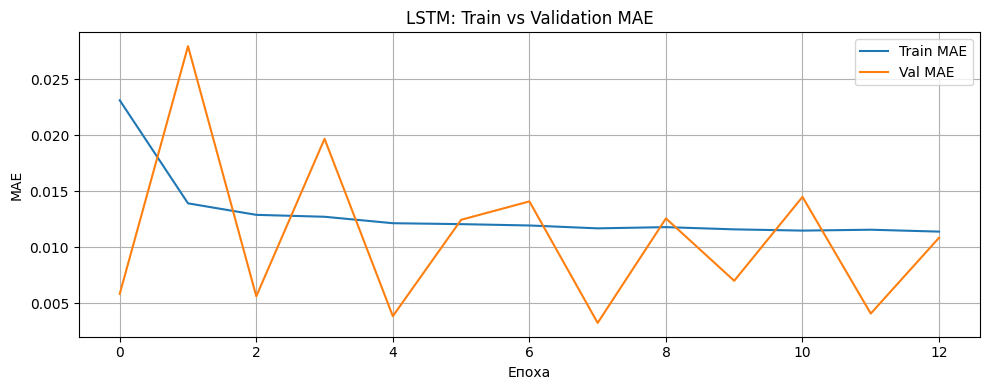

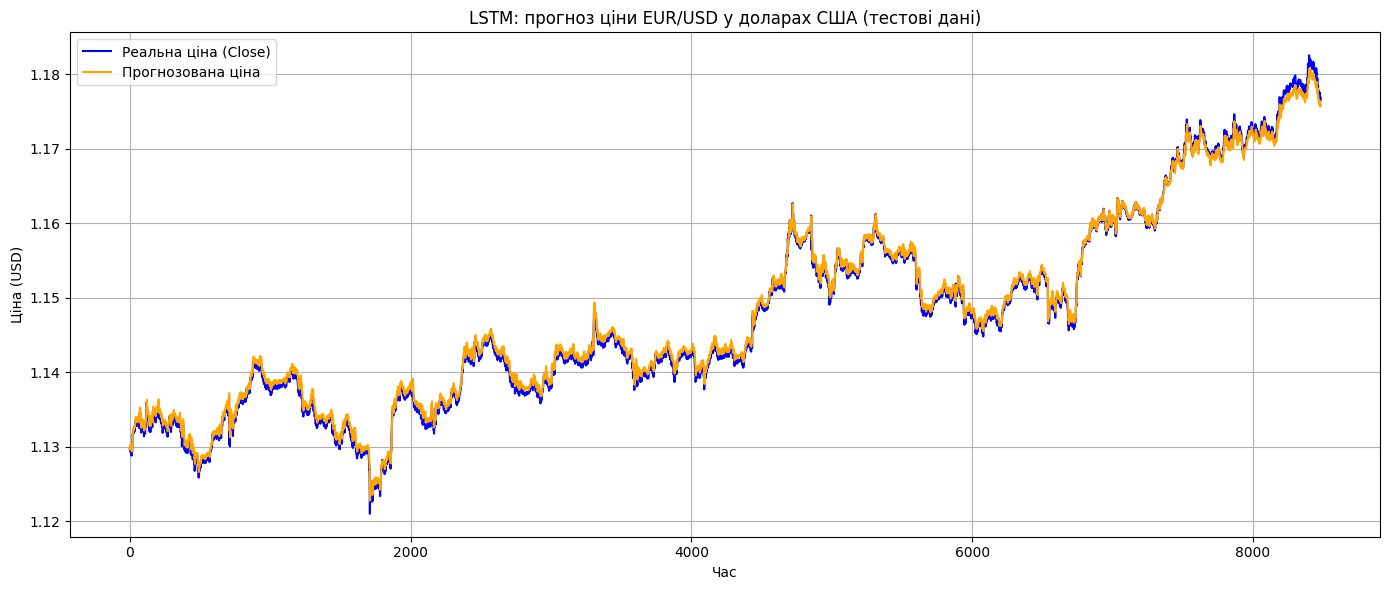

🟦 Реальні свічки:


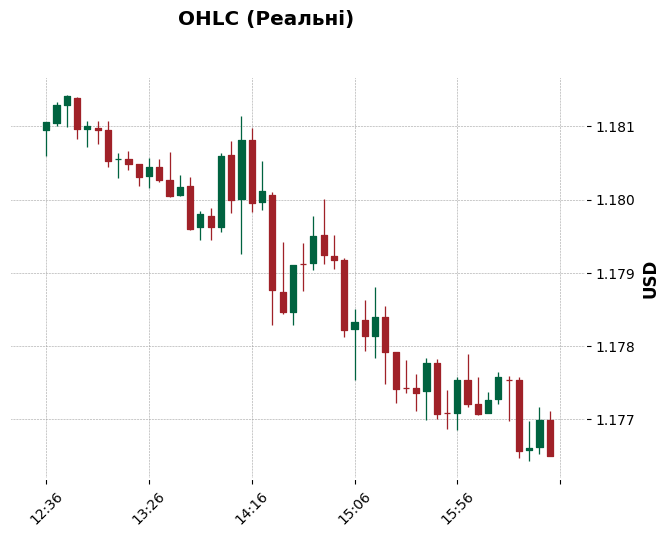

🟩 Live прогноз OHLC:


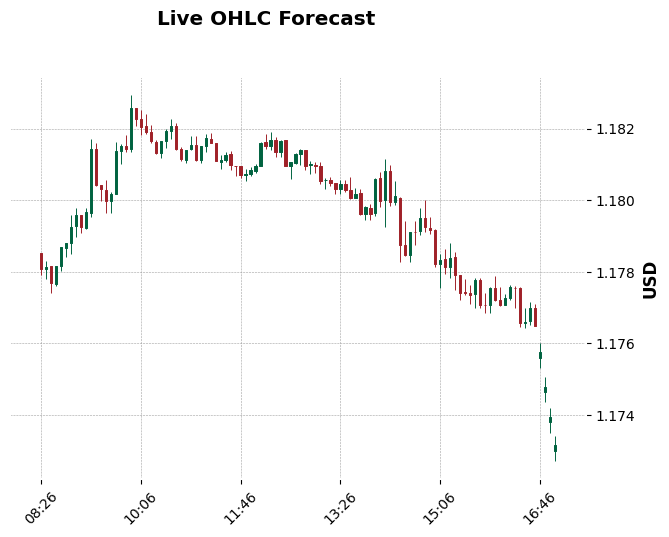

In [16]:
main()